# Book Recommendation System - PART 2 (Modeling)

by: [Ulya Azmah Khairiah](https://www.linkedin.com/in/ulyazmah/)

In my first notebook, I tried to explore the data and answer several deep dive questions. From that exploration, we observed that people start to give lower rating if they read more books. We thought that this could be a result of an inappropriate book recommendation system, so that people end up reading books they don't like. 

Now, it's time for us to to develop recommendation systems. In this notebook, the recommendation systems developed based on several methods: 
1. Basic Recommender
2. Content-based Filtering
3. Collaborative Filtering

In the end, I will compare the result given by the recommendation systems and explore strengths and weakness of each model.

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for content based filtering
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

#for collaborative filtering
import os
import math
import random

from surprise import accuracy, Reader, Dataset, dump
from surprise import NormalPredictor, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV

## Import Dataset

In [2]:
pd.options.display.float_format = '{:.2f}'.format
r = pd.read_csv('data/ratings.csv')
b = pd.read_csv('data/books_cleaned.csv')

## 1. Simple Recommendation

One of the easiest way to give recommendation is to rank the book based on `average_rating` or `rating_count` (popularity). However, as we mentioned in EDA, we found:
1. Book with relatively lower number of `rating_count` (less popular) when we rank book based on `average_rating`.
2. Book with relatively lower `average_rating` when we ranked book based on `rating_count`.

Therefore, we need to make a weighted rating of `average_rating` and `rating_count`.

### a. Recommendation based on Weighted Average of Rating and Popularity

One of the easiest way to give recommendation is to rank the book in metadata based on average_rating or rating_count (popularity). However, as we mentioned in the EDA phase, we found:
1. Book with relatively lower number of rating_count (less popular) when we rank book based on average_rating.
2. Book with relatively lower average_rating when we ranked book based on rating_count.

Therefore, we need to make a new scoring of average_rating and rating_count. In this case, I will use rating formula like the one used in IMDB site to determine the Top Rated 250 Movies.

New Rating Score is determined by the following equation:
![New Rating Formula](img/new_rating_score.png "New Rating Score")

where:<br>
v = number of ratings (`ratings_count`)<br>
m = minimum `ratings_count` required to be recommended<br>
R = average of ratings (`average_rating`) <br>
C = the mean ratings for all books

Now let's determine the appropriate value for m, the number of votes needed to be listed in the chart. For this simple recommender, our cutoff will be the 95th percentile. In order for a book to appear in the recommendation, it must receive at least 95% of the other books on the list (around 2100 ratings).

In [3]:
def simple_recommender(books, n=5):
    v = books['ratings_count']
    m = books['ratings_count'].quantile(0.95)
    R = books['average_rating']
    C = books['average_rating'].median()
    score = (v/(v+m) * R) + (m/(m+v) * C)   
    books['score'] = score
    
    qualified  = books.sort_values('score', ascending=False)
    return qualified[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','score']].head(n)

In [4]:
simple_recommender(b)

,book_id,title,authors,average_rating,ratings_count,score
21,25,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,4.61,1746574,4.56
23,27,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1678823,4.49
15,18,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.53,1832823,4.49
20,24,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.53,1753043,4.48
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.44,4602479,4.43


### b. Evaluation

This system offers generalized recommendations to every user based on popularity and average rating of the book. The recommender some flaws. For example, it makes the same suggestion to everyone, regardless of their own preferences. The top of our chart is full with J.K. Rowling's Harry Potter novels.

In order to personalize of our recommendations, we are going to create recommendation system that compares books based on a set of metrics and suggests books that are most similar to a particular book that a user liked.

## 2. Content Based Recommendation System

### a. Recommendation based on Cosine Similarity

To personalise our recommendations, we will measure the cosine similarity between books. The steps are:

1. Make new column which consist of authors, title, genres and description of each book. <br>
2. Use `TFIDFVectorizer` to convert our data to vector
3. Calculate the cosine similarity score for all books
4. User will input their favorite book, we will sort book that more similar to the input
5. Recommend a user books

Since we use `TFIDFVectorizer`, the dot product will directly give us the cosine similarity score. Therefore, we will use `sklearn`'s `linear_kernel` instead of `cosine_similarities` since it is much faster.

In [5]:
def content(books):
    books['content'] = (pd.Series(books[['authors', 'title', 'genres', 'description']]
                                  .fillna('')
                                  .values.tolist()
                                  ).str.join(' '))

    tf_content = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tfidf_matrix = tf_content.fit_transform(books['content'])
    cosine = linear_kernel(tfidf_matrix, tfidf_matrix)
    index = pd.Series(books.index, index=books['title'])

    return cosine, index

In [6]:
def content_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n + 1]
    book_indices = [i[0] for i in sim_scores]
    return books[['book_id', 'title', 'authors', 'average_rating', 'ratings_count']].iloc[book_indices]

In [7]:
content_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,4.26,116197
2048,2187,We,Yevgeny Zamyatin,3.95,40020
3670,4004,Homage to Catalonia,George Orwell,4.14,22227
6857,8056,"1Q84 #1-2 (1Q84, #1-2)",Haruki Murakami,4.07,8342
4915,5510,The Far Side Gallery,Gary Larson,4.42,20022


Notice that the system recommends a book with average_rating (3.95) lower than average and book with low `ratings_count` (8342). We will try to improve our recommendation by adding popularity-rating filter.

### b. Content Based + Popularity-Rating Filter

The mechanism to remove books with low ratings has been added on top of the content based filtering. This system will return books that are similar to your input, are popular and have high ratings. However, in this filter, our cutoff will be the quantile 75. In order for a book to appear in the recommendation, it must be ranked in top 25 similar and receive at least 75% weight score of the other books on the list (around 800 ratings).

In [8]:
def improved_recommendation(books, title, n=5):
    cosine_sim, indices = content(books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    book_indices = [i[0] for i in sim_scores]
    books2 = books.iloc[book_indices][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]

    v = books2['ratings_count']
    m = books2['ratings_count'].quantile(0.75) #here the minimum rating is quantile 75
    R = books2['average_rating']
    C = books2['average_rating'].median()
    books2['new_score'] = (v/(v+m) * R) + (m/(m+v) * C)

    high_rating = books2[books2['ratings_count'] >= m]
    high_rating = high_rating.sort_values('new_score', ascending=False)

    return high_rating[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','new_score']].head(n)

In [9]:
improved_recommendation(b, '1984')

,book_id,title,authors,average_rating,ratings_count,new_score
795,846,Animal Farm / 1984,George Orwell,4.26,116197,4.20
759,809,Brave New World / Brave New World Revisited,Aldous Huxley,4.16,108124,4.13
1044,1120,Aesop's Fables,Aesop,4.05,88508,4.05
8316,2375,"Tinker, Tailor, Soldier, Spy",John le Carré,4.04,40871,4.04
604,649,1Q84,Haruki Murakami,3.89,125195,3.93


### c. Evaluation

This method is suitable for people who are looking for similar books, but this system can not capture tastes and provide recommendations across genres. Therefore, we will try to build a recommendation system using Collaborative filtering.

## 3. Collaborative Filtering

This system suggests book to users based on past reading history and collaboration of other users' preferences. This recommender systems provides personalized recommendation. In this notebook, I will use [Surprise](https://surpriselib.com/) library to make the recommendation system. Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. I will try to fit into 4 model and evaluate by using RMSE value. The model I use:
1. **Normal Predictor**
2. **KNN** (Memory-based)
3. **SVD** (Model-based)
4. **SVD++** (Model-based)

Since the calculation is taking to much memory, I dump the calculation file in order to reuse it for comparison. I will also test all the recommendation system to user 12874. This user is one of the user that give many ratings.

In [3]:
#to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [4]:
#Load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(r, reader)

In [5]:
#shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

In [6]:
#split data into train and test data with the ratio 70:30
threshold = int(0.7 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

In [7]:
def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(b['book_id'])
    book_read_list = list(r['book_id'][r['user_id'] == user_id])
    return books_list, book_read_list

### a. Normal Predictor

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [15]:
# prepare train data
data.raw_ratings = train_ratings

#select algorithm
npred = NormalPredictor()

In [16]:
%%time

#cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=2)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3232  1.3233  1.3220  1.3223  1.3243  1.3230  0.0008  
Fit time          3.17    4.75    3.14    4.78    3.14    3.80    0.79    
Test time         12.99   10.18   12.31   10.26   8.39    10.83   1.65    
CPU times: user 1min 32s, sys: 3.55 s, total: 1min 35s
Wall time: 1min 56s


In order to make prediction on test data, we have to retrain whole train set first.

In [17]:
%%time
#retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)

Train RMSE:
RMSE: 1.3233
Test RMSE:
RMSE: 1.3236
CPU times: user 1min 37s, sys: 1.14 s, total: 1min 38s
Wall time: 1min 38s


In [18]:
# uncomment this code to dump the calculation result for future use
# dump.dump('./dump_np', np_test_pred, npred)

Now we can get recommendation for user 12874

In [19]:
%%time

data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

CPU times: user 23.6 s, sys: 400 ms, total: 24 s
Wall time: 24 s


In [20]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [21]:
get_recommendation_npred(12874, 5)

,book_id,title,authors,average_rating,ratings_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
5,6,The Fault in Our Stars,John Green,4.26,2346404
24,28,Lord of the Flies,William Golding,3.64,1605019
39,45,Life of Pi,Yann Martel,3.88,1003228
40,46,Water for Elephants,Sara Gruen,4.07,1068146


### b. K-Nearest Neighbour

These are algorithms that are directly derived from a basic nearest neighbors approach.

In [8]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
sim_options = {"name": "cosine",
               "user_based": False}
knn = KNNBasic(sim_options=sim_options)

In [9]:
%%time

#cross validation for train data
knn_result = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True, n_jobs = 1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8878  0.8876  0.8861  0.8872  0.8890  0.8876  0.0009  
Fit time          21.83   23.65   23.47   23.28   23.54   23.16   0.67    
Test time         108.82  112.19  113.72  110.50  105.97  110.24  2.69    
CPU times: user 11min 54s, sys: 11.4 s, total: 12min 6s
Wall time: 12min 6s


In [10]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
knn.fit(trainset)

# Compute RMSE on trainset (without fold)
knn_train_pred = knn.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(knn_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
knn_test_pred = knn.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(knn_test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Train RMSE:
RMSE: 0.8001
Test RMSE:
RMSE: 0.8851
CPU times: user 13min, sys: 3.38 s, total: 13min 3s
Wall time: 13min 3s


In [11]:
# uncomment this code to dump the calculation result for future use
# dump.dump('./dump_knn', knn_test_pred, knn)

Now we can get recommendation for user 12874

In [9]:
%%time

data.raw_ratings = all_ratings
knn.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 1min 12s, sys: 2.25 s, total: 1min 14s
Wall time: 1min 14s


In [10]:
def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = knn.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [11]:
get_recommendation_knn(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
89,98,"The Girl Who Played with Fire (Millennium, #2)",Stieg Larsson,4.22,563994
103,114,Tuesdays with Morrie,Mitch Albom,4.06,556518
118,132,The Five People You Meet in Heaven,Mitch Albom,3.90,449501
126,140,The Girl Who Kicked the Hornet's Nest (Millenn...,Stieg Larsson,4.20,443951


### c. Singular Value Decomposition (SVD)

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. SVD finds the latent factors associated with some matrix. SVD will decompose user-rating matrix into matrices that represents latent user-user features and item-item features.

In [8]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
svd = SVD(random_state=0)

In [9]:
%%time

#cross validation for train data
svd_result = cross_validate(svd, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8503  0.8500  0.8484  0.8503  0.8510  0.8500  0.0009  
Fit time          46.56   45.32   46.15   41.94   32.70   42.53   5.18    
Test time         9.49    12.47   9.49    10.48   9.61    10.30   1.14    
CPU times: user 1min 32s, sys: 3.3 s, total: 1min 35s
Wall time: 3min 14s


In [10]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# Compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)

Train RMSE:
RMSE: 0.6441
Test RMSE:
RMSE: 0.8386
CPU times: user 2min 48s, sys: 1.35 s, total: 2min 49s
Wall time: 2min 49s


In [11]:
# uncomment this code to dump the calculation result for future use
# dump.dump('./dump_svd', svd_test_pred, svd)

Now we can get recommendation for user 12874

In [12]:
%%time

data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

CPU times: user 1min 56s, sys: 379 ms, total: 1min 56s
Wall time: 1min 56s


In [13]:
def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svd.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [14]:
get_recommendation_svd(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
194,215,Ready Player One,Ernest Cline,4.31,349423
226,250,Wonder,R.J. Palacio,4.43,228538
390,425,Go Ask Alice,Beatrice Sparks,3.77,196677
1698,1808,"Morning Star (Red Rising, #3)",Pierce Brown,4.50,47736


### d. SVD++

The singular value decomposition (SVD)++ algorithm is employed as an optimized SVD algorithm to enhance the accuracy of prediction by generating implicit feedback.

In [8]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
svdpp = SVDpp(random_state=0)

In [9]:
%%time

svdpp_result = cross_validate(svdpp, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8325  0.8315  0.8298  0.8313  0.8326  0.8315  0.0010  
Fit time          452.81  450.51  448.53  446.92  438.23  447.40  4.99    
Test time         66.38   66.49   66.61   66.60   66.31   66.48   0.12    
CPU times: user 1min 33s, sys: 3.76 s, total: 1min 36s
Wall time: 26min 19s


In [10]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
svdpp.fit(trainset)

# Compute RMSE on trainset (without fold)
svdpp_train_pred = svdpp.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdpp_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdpp_test_pred = svdpp.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdpp_test_pred)

Train RMSE:
RMSE: 0.7085
Test RMSE:
RMSE: 0.8238
CPU times: user 22min 28s, sys: 4.05 s, total: 22min 32s
Wall time: 22min 29s


In [11]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_svdpp', svdpp_test_pred, svdpp)

Now we can get recommendation for user 12874

In [12]:
%%time

data.raw_ratings = all_ratings
svdpp.fit(data.build_full_trainset())

CPU times: user 25min 17s, sys: 344 ms, total: 25min 18s
Wall time: 25min 18s


In [13]:
def get_recommendation_svdpp(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdpp.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [14]:
get_recommendation_svdpp(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
597,642,"World Without End (The Kingsbridge Series, #2)",Ken Follett,4.23,128715
1243,1328,"I Am Pilgrim (Pilgrim, #1)",Terry Hayes,4.23,49740
4310,4778,The Holy Bible: English Standard Version,Anonymous,4.66,17863
5302,5990,الطنطورية,Radwa Ashour,4.32,13931


### e. Evaluation

In [3]:
#uncomment this code to load the dump file
np_test_pred, npred = dump.load('./dump_np')
knn_test_pred, knn = dump.load('./dump_knn')
svd_test_pred, svd = dump.load('./dump_svd')
svdpp_test_pred, svdpp = dump.load('./dump_svdpp')

In [4]:
#making the calculation reult into dataframe
df_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_knn = pd.DataFrame(knn_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])  
df_svdpp = pd.DataFrame(svdpp_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

#### Comparing RMSE, Duration and Memory Use

In [5]:
data = [['NP', 1.3236, '3m 40s', 8.7], ['KNN', 0.8851, '24m 45s', 16], ['SVD', 0.8386, '7m 5s', 8.8],  ['SVD++', 0.8238, '1h 9m 50s', 8.4]]
df = pd.DataFrame(data, columns=['Model', 'RMSE', 'Duration', 'Memory Use'])
df

,Model,RMSE,Duration,Memory Use
0,NP,1.32,3m 40s,8.70
1,KNN,0.89,24m 45s,16.00
2,SVD,0.84,7m 5s,8.80
3,SVD++,0.82,1h 9m 50s,8.40


By comparing the metric evaluation of four model, we get the lowest RMSE in SVD++. However, although SVD++ shows lower RMSE results, it takes a very long time to do the calculations. If we look at the rating predictions, the distribution of ratings on SVD and SVD++ is not much different. 

**Why KNN took longer time to run?** <br>
The singular value decomposition (SVD)++ algorithm enhances the accuracy of prediction by generating implicit feedback so it takes considerably longer time to train, compared to the SVD.

**Why KNN requires lot of memory?** <br>
K-nearest neighbor (KNN) needs a lot of memory, since the recommendation systems rely on storing a sizable dataset of items and their properties in order to create suggestions. When a new item is added or a recommendation is needed, the KNN method must scan the entire dataset to discover the closest neighbors, which can be computationally intensive and demand a lot of memory.

#### Comparing Prediction Distribution

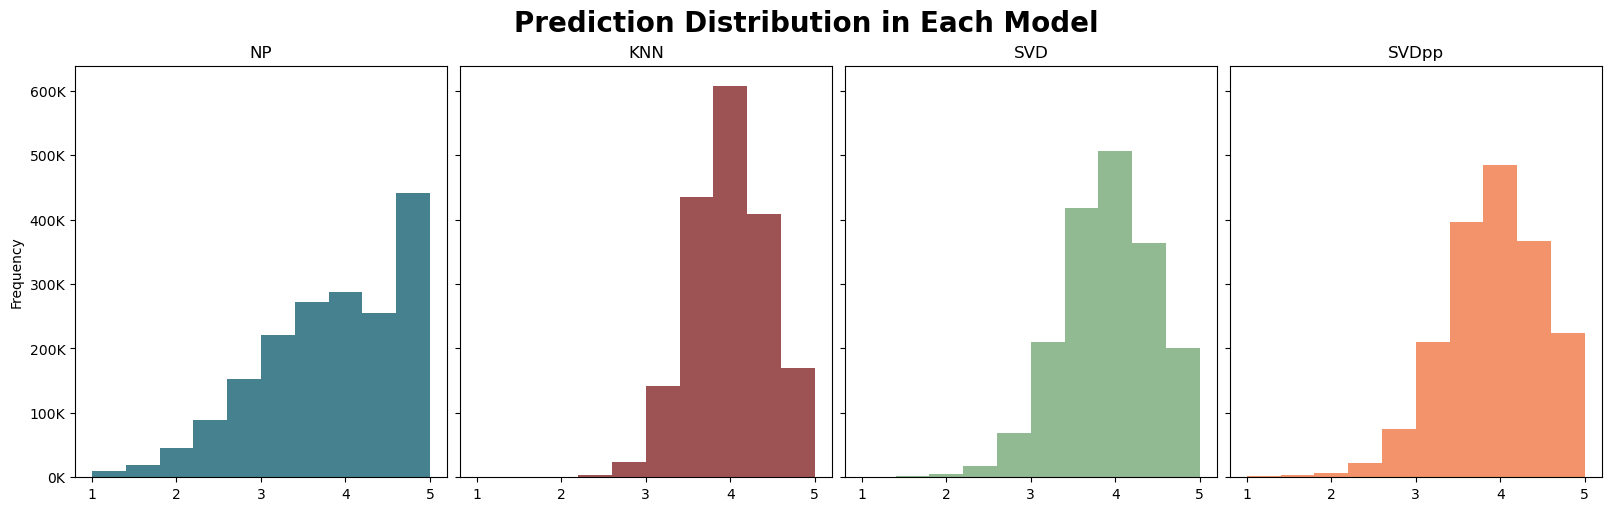

In [6]:
# Count the number of predictions for each rating value
figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(16, 5), sharey=True, constrained_layout=True)
df_np.est.plot(kind='hist', title='NP', ax=ax1, color='#45818E')
df_knn.est.plot(kind='hist', title='KNN', ax=ax2, color='#9D5353')
df_svd.est.plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
df_svdpp.est.plot(kind='hist', title='SVDpp', ax=ax4, color='#F3936B')
current_values = plt.gca().get_yticks() / 1000
plt.gca().set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in current_values])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=20)
plt.show()

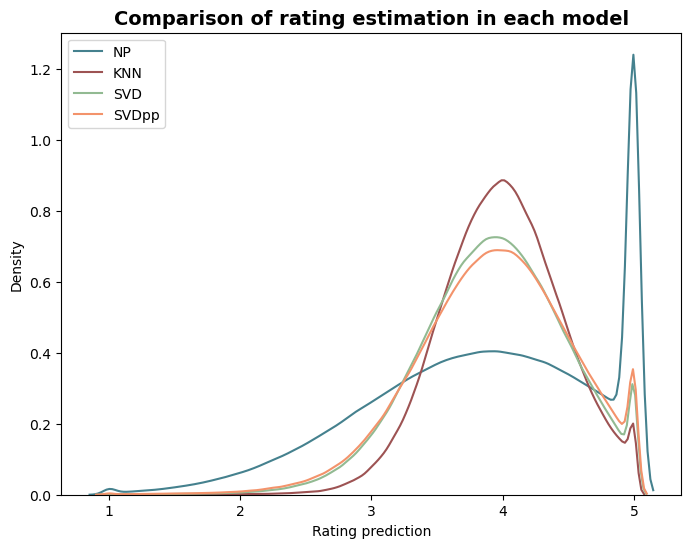

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_np['est'], shade=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(df_knn['est'], shade=False, color='#9D5353', label = 'KNN', ax=ax)
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdpp['est'], shade=False, color='#F3936B', label = 'SVDpp', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

As we can see, Normal Predictor model predicts higher ratings more often, meanwhile KNN predictions are concentrated around the mean. For SVD and SVD++, the ratings are more fairly distributed.

## Hyperparameter Tuning on Best Model

Based on our comparison, we choose SVD as the best model. SVD was chosen because it has a relatively low RMSE value, relatively short processing time and the memory used is not too large.<br>
To tune the hyperparameter, we can utilize grid search, an optimization technique that explores all possibilities of the provided hyperparameter options. The parameters that will be tuned are:
- n_epochs: the number of iterations of the SGD procedure
- lr_all: the learning rate for all parameters
- reg_all: the regularization term for all parameters

In [8]:
# prepare train data
data.raw_ratings = train_ratings

In [9]:
%%time

grid = {'n_epochs': [20, 30], 
        'lr_all': [.005, .001], 
        'reg_all': [0.02, 0.04]} 

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=5, n_jobs=2)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8384557922653402
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.04}
CPU times: user 4min 4s, sys: 10.7 s, total: 4min 15s
Wall time: 17min 33s


In [10]:
#select best algorithm
svdtuned = gs.best_estimator['rmse']

In [11]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

# Compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

Train RMSE:
RMSE: 0.6577
Test RMSE:
RMSE: 0.8270
CPU times: user 3min 21s, sys: 1.61 s, total: 3min 23s
Wall time: 3min 23s


In [12]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

CPU times: user 2min 50s, sys: 254 ms, total: 2min 50s
Wall time: 2min 50s


In [13]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [14]:
get_recommendation(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
241,267,The Nightingale,Kristin Hannah,4.54,253606
3457,3753,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73,24618
6024,6920,The Indispensable Calvin and Hobbes,Bill Watterson,4.73,14597
7466,8946,The Divan,Hafez,4.63,2773


In [15]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_tuning', svdtuned_test_pred, svdtuned)

In [3]:
# uncomment this code to load the dump file
svd_test_pred, svd = dump.load('./dump_svd')
svdtuned_test_pred, svdtuned = dump.load('./dump_tuning')

In [4]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

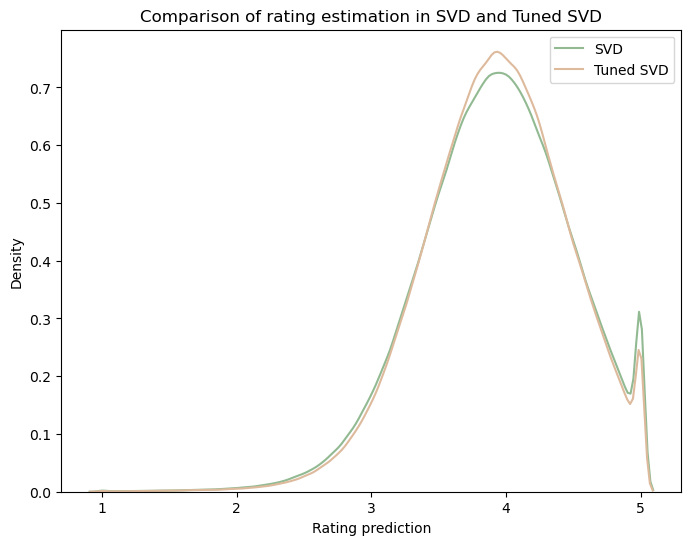

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], shade=False, color='#DEBA9D', label = 'Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()

Rating prediction around the mean is higher in tuned SVD. This is probably as a result of higher `reg_all`, so the parameter are regularized.

## Conclusion

1. **Simple Recommender** <br>
Like the name suggests, this model offers the simple recommendation.  This model does not provide user-spesific recommendations but suitable for new user (have no cold-start problem). Cold problem refers to a problem when the system is unable to draw any conclusions about users or objects because it has not yet acquired enough data.


2. **Content based filtering** <br>
Recommendations based on title, authors, description, and genre using cosine similarity have been made. To provide a balance of book recommendations, an additional popularity-rating filter has been added. This method is suitable for people who are looking for books that are similar to their favorite books, but this system cannot capture tastes and provide recommendations across genres.
By applying a content based model, instead of having to rate 30 books to start the recommendation engine, users can just pick one book they liked for Goodreads to provide good recommendations for new users, making the process easier.


3. **Collaborative Filtering**<br>
By using Surprise library, I tried building a recommender with 4 algorithms: Normal Predictor, KNN, SVD, and SVD++. SVD is suitable for making a recommendation system in Goodreads because of its lower RMSE, faster calculation and lower memory requirement unlike KNN. I think the RMSE value of 0.8 is still quite reasonable for a Goodreads rating.<br>
Notice that Collaborative filtering doesn’t require features about the items or users to be known. We can only use rating data. However, this recommendation system need prior data and suffers cold start problem, for example when new user or new book added to the list. 